## Coursework 3 Template

In [9]:
# Graph Mining Homework: Facebook Social Network

# Import necessary libraries
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- 1. Load the Dataset ---
print("--- 1. Load the Dataset ---")

# Define file paths
file_path_edges = 'facebook_combined.csv'
file_path_names = 'names.csv'

# Initialize graph variable
G = None
df_edges = None

try:
    # --- Load the edgelist using pandas with COMMA delimiter and HEADER row ---
    print(f"Attempting to load '{file_path_edges}' with COMMA delimiter, using the FIRST row as HEADER...")
    df_edges = pd.read_csv(
        file_path_edges,
        delimiter=','    # Correct delimiter
        # header=0      # Default: Use the first row as header (can omit this line)
    )

    # Display the first few rows, columns, and data types to verify
    print("\nSuccessfully loaded DataFrame. First 5 rows:")
    print(df_edges.head())
    print("\nColumn names from header:", df_edges.columns.tolist())
    print("\nData types of columns:")
    print(df_edges.dtypes)

    # --- Data Validation ---
    # Check if we have at least two columns
    if len(df_edges.columns) >= 2:
        # Get the actual column names from the header
        source_col = df_edges.columns[0]
        target_col = df_edges.columns[1]
        print(f"\nUsing column '{source_col}' as source and '{target_col}' as target.")

        # Check if the columns are numeric (pandas should infer this correctly now)
        if pd.api.types.is_numeric_dtype(df_edges[source_col]) and pd.api.types.is_numeric_dtype(df_edges[target_col]):
            print("\nData types seem correct (numeric).")

            # Ensure columns are integer type (just to be safe)
            df_edges[source_col] = df_edges[source_col].astype(int)
            df_edges[target_col] = df_edges[target_col].astype(int)
            print("Converted columns to integer type.")

            # --- Create Graph ---
            G = nx.from_pandas_edgelist(
                df_edges,
                source=source_col,      # Use the actual name of the first column
                target=target_col,      # Use the actual name of the second column
                create_using=nx.Graph() # Undirected graph
            )

            print(f"\nSuccessfully created graph from '{file_path_edges}'.")
            print(f"Graph Type: {type(G)}")
            print(f"Number of nodes loaded: {G.number_of_nodes()}")
            print(f"Number of edges loaded: {G.number_of_edges()}")

        else:
            print("\nError: Loaded columns are not purely numeric even with header processing.")
            print(f"Data types found: {df_edges.dtypes}")
            G = None
    else:
        print("\nError: Did not find at least two columns after reading the header.")
        G = None


except FileNotFoundError:
    print(f"Error: File not found at '{file_path_edges}'. Please ensure the file is in the correct directory.")
    G = None
except Exception as e:
    print(f"An error occurred during loading: {e}")
    G = None


# --- Load Names (Keep previous robust version) ---
name_map = {}
try:
    print(f"\nAttempting to load '{file_path_names}'...")
    names_df = pd.read_csv(
        file_path_names,
        sep=r'\s+',       # Flexible whitespace
        header=None,
        names=['User ID', 'Name'],
        engine='python'
    )
    print("Successfully loaded names file. First 5 rows:")
    print(names_df.head())

    if 'User ID' in names_df.columns and 'Name' in names_df.columns:
        names_df['User ID'] = pd.to_numeric(names_df['User ID'], errors='coerce')
        names_df.dropna(subset=['User ID'], inplace=True)
        names_df['User ID'] = names_df['User ID'].astype(int)
        name_map = pd.Series(names_df.Name.values, index=names_df['User ID']).to_dict()
        print(f"Created name map with {len(name_map)} entries.")
    else:
        print("Could not find expected columns 'User ID' and 'Name' in names file.")

except FileNotFoundError:
    print(f"Warning: '{file_path_names}' not found. Proceeding without names.")
    name_map = {}
except Exception as e:
    print(f"Warning: Could not process '{file_path_names}'. Error: {e}")
    name_map = {}


# --- Answering Questions from Section 1 ---
print("\nAnswers to Section 1 Questions:")
if G:
    print(f" - Graph loaded successfully from '{file_path_edges}'.")
    print(f"   - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    print(" - What does a node show? A Facebook user ID (integer).")
    print(f" - Is the graph undirected? Yes ({type(G)}).")
    print(" - Undirected assumption affect methods? Yes (degree, centrality, paths, communities).")
    print(" - Make undirected from directed adjacency matrix A? A_undir = max(A, A.T).")
    print(" - Need to change data? No.")
else:
    print("\nGraph (G) was not successfully created. Cannot answer Section 1 questions about the graph object.")
    print("Please check the file path, delimiter, header, and review any error messages above.")

--- 1. Load the Dataset ---
Attempting to load 'facebook_combined.csv' with COMMA delimiter, using the FIRST row as HEADER...

Successfully loaded DataFrame. First 5 rows:
   first user   second user
0            0         3752
1            0         3571
2            0         3938
3            0         1033
4            0         3228

Column names from header: ['first user ', 'second user']

Data types of columns:
first user     int64
second user    int64
dtype: object

Using column 'first user ' as source and 'second user' as target.

Data types seem correct (numeric).
Converted columns to integer type.

Successfully created graph from 'facebook_combined.csv'.
Graph Type: <class 'networkx.classes.graph.Graph'>
Number of nodes loaded: 4032
Number of edges loaded: 87044

Attempting to load 'names.csv'...
Successfully loaded names file. First 5 rows:
            User ID     Name
0              User  ID,Name
1     0,xbkNqALuRoY     None
2       1,hisLX6dAr     None
3    2,ummk2eugX92L

In [14]:
# --- Subgraph Creation (Due to Performance Issues) ---
print("\n--- Subgraph Creation ---")

# Check if the original graph G exists
if G:
    num_original_nodes = G.number_of_nodes()
    print(f"Original graph has {num_original_nodes} nodes and {G.number_of_edges()} edges.")

    # --- Define Sample Size ---
    # Let's aim for around 800 nodes. Adjust as needed.
    sample_size = 800
    if sample_size >= num_original_nodes:
        print("Sample size is larger than or equal to original graph size. Using original graph.")
        G_sub = G.copy() # Use a copy to avoid modifying original G if needed later
    else:
        print(f"Creating a subgraph with approximately {sample_size} nodes due to performance considerations (especially for Girvan-Newman).")

        # --- Random Node Sampling ---
        # Select a random sample of nodes
        random_nodes = random.sample(list(G.nodes()), sample_size)

        # --- Create Induced Subgraph ---
        # The induced subgraph contains the sampled nodes and ALL edges
        # that exist between these nodes in the original graph.
        G_sub = G.subgraph(random_nodes).copy() # Use .copy() to make it mutable if needed

        print(f"Subgraph created with {G_sub.number_of_nodes()} nodes and {G_sub.number_of_edges()} edges.")

        # --- IMPORTANT: Note on Analysis ---
        print("\nNOTE: All subsequent analysis (Steps 2-6) will be performed on this SUBGRAPH ('G_sub').")
        print("This is done to ensure reasonable computation times, as permitted by course guidelines.")

else:
    print("Original graph 'G' not loaded. Cannot create subgraph.")
    G_sub = None # Ensure G_sub is None if G doesn't exist

# --- Optional: Sanity Check ---
# if G_sub:
#     print(f"Subgraph density: {nx.density(G_sub):.6f}")
#     print(f"Is subgraph connected? {nx.is_connected(G_sub)}")
#     if not nx.is_connected(G_sub):
#         print(f"Subgraph components: {nx.number_connected_components(G_sub)}")


--- Subgraph Creation ---
Original graph has 4032 nodes and 87044 edges.
Creating a subgraph with approximately 800 nodes due to performance considerations (especially for Girvan-Newman).
Subgraph created with 800 nodes and 3562 edges.

NOTE: All subsequent analysis (Steps 2-6) will be performed on this SUBGRAPH ('G_sub').
This is done to ensure reasonable computation times, as permitted by course guidelines.


In [15]:
# --- 2. Basic Graph Properties (on Subgraph) --- # MODIFIED
print("\n--- 2. Basic Graph Properties (on Subgraph) ---") # MODIFIED

# Check if subgraph G_sub exists and is not empty
if 'G_sub' in locals() and G_sub and G_sub.number_of_nodes() > 0: # MODIFIED Check for G_sub
    # Show Number of nodes and edges
    num_nodes = G_sub.number_of_nodes() # MODIFIED G -> G_sub
    num_edges = G_sub.number_of_edges() # MODIFIED G -> G_sub
    print(f"Subgraph: Number of nodes: {num_nodes}") # MODIFIED Note it's subgraph
    print(f"Subgraph: Number of edges: {num_edges}") # MODIFIED Note it's subgraph

    # Calculate Graph density
    density = nx.density(G_sub) # MODIFIED G -> G_sub
    print(f"Subgraph: Graph density: {density:.6f}") # MODIFIED Note it's subgraph

    # Interpretation... (same logic)
    if density < 0.01:
        density_desc = "very sparse"
    elif density < 0.1:
        density_desc = "sparse"
    elif density < 0.5:
        density_desc = "moderate"
    else:
        density_desc = "dense"
    print(f"Subgraph: Interpretation: The graph is {density_desc}.") # MODIFIED Note it's subgraph

    # Check connectivity
    is_connected = nx.is_connected(G_sub) # MODIFIED G -> G_sub
    print(f"Subgraph: Is the graph connected? {is_connected}") # MODIFIED Note it's subgraph

    # Find the number of connected components
    if is_connected:
        num_components = 1
        print("Subgraph: Number of connected components: 1") # MODIFIED Note it's subgraph
    else:
        print("Subgraph: Calculating number of connected components...") # MODIFIED Note it's subgraph
        num_components = nx.number_connected_components(G_sub) # MODIFIED G -> G_sub
        print(f"Subgraph: Number of connected components: {num_components}") # MODIFIED Note it's subgraph

else:
    print("Subgraph 'G_sub' is not created or is empty. Cannot calculate properties.") # MODIFIED Check G_sub


--- 2. Basic Graph Properties (on Subgraph) ---
Subgraph: Number of nodes: 800
Subgraph: Number of edges: 3562
Subgraph: Graph density: 0.011145
Subgraph: Interpretation: The graph is sparse.
Subgraph: Is the graph connected? False
Subgraph: Calculating number of connected components...
Subgraph: Number of connected components: 4


In [16]:
# --- 3. Node-Level Analysis (on Subgraph) --- # MODIFIED
print("\n--- 3. Node-Level Analysis (on Subgraph) ---") # MODIFIED

if 'G_sub' in locals() and G_sub and G_sub.number_of_nodes() > 0: # MODIFIED Check for G_sub
    # --- Degree Centrality ---
    print("\nCalculating Degree Centrality (Subgraph)...")
    # Use G_sub
    degrees_sub = dict(G_sub.degree()) # MODIFIED G -> G_sub

    # Sort nodes by degree in descending order
    sorted_degrees_sub = sorted(degrees_sub.items(), key=lambda item: item[1], reverse=True) # MODIFIED variable name

    print("\nTop 5 nodes with the highest degree (Subgraph):") # MODIFIED Note Subgraph
    # Print the top 5
    for i in range(min(5, len(sorted_degrees_sub))): # MODIFIED variable name
        node_id, degree_val = sorted_degrees_sub[i] # MODIFIED variable name
        # Retrieve original degree from the full graph G for context, if desired
        original_degree = G.degree(node_id) if G and node_id in G else 'N/A'
        print(f"  Node ID: {node_id:<5} | Subgraph Degree: {degree_val:<4} | Original Degree: {original_degree}") # Show both degrees

    # --- Betweenness Centrality ---
    print("\nCalculating Betweenness Centrality (Subgraph - should be faster)...") # MODIFIED Note Subgraph
    try:
        # Use G_sub
        betweenness_centrality_sub = nx.betweenness_centrality(G_sub, k=None, normalized=True, endpoints=False) # MODIFIED G -> G_sub
        print("Betweenness Centrality calculation complete (Subgraph).") # MODIFIED Note Subgraph

        # Find the node with the maximum betweenness centrality in the subgraph
        max_bc_node_sub = max(betweenness_centrality_sub, key=betweenness_centrality_sub.get) # MODIFIED variable name
        max_bc_value_sub = betweenness_centrality_sub[max_bc_node_sub] # MODIFIED variable name

        print(f"\nNode with the highest Betweenness Centrality (Subgraph):") # MODIFIED Note Subgraph
        print(f"  Node ID: {max_bc_node_sub}")
        print(f"  Normalized Betweenness Centrality Value (Subgraph): {max_bc_value_sub:.6f}") # MODIFIED Note Subgraph

    except Exception as e:
        print(f"An error occurred during betweenness centrality calculation (Subgraph): {e}") # MODIFIED Note Subgraph
        max_bc_node_sub = None # MODIFIED variable name

else:
    print("Subgraph 'G_sub' is not created or is empty. Cannot perform Node-Level Analysis.") # MODIFIED Check G_sub


--- 3. Node-Level Analysis (on Subgraph) ---

Calculating Degree Centrality (Subgraph)...

Top 5 nodes with the highest degree (Subgraph):
  Node ID: 107   | Subgraph Degree: 178  | Original Degree: 936
  Node ID: 1912  | Subgraph Degree: 144  | Original Degree: 702
  Node ID: 0     | Subgraph Degree: 73   | Original Degree: 345
  Node ID: 2090  | Subgraph Degree: 44   | Original Degree: 159
  Node ID: 1917  | Subgraph Degree: 43   | Original Degree: 212

Calculating Betweenness Centrality (Subgraph - should be faster)...
Betweenness Centrality calculation complete (Subgraph).

Node with the highest Betweenness Centrality (Subgraph):
  Node ID: 107
  Normalized Betweenness Centrality Value (Subgraph): 0.237313



--- 4. Community Detection (Girvan-Newman - on Subgraph) ---
Attempting to compute the FIRST level partition on the subgraph.
Calculating level 1 partition (Subgraph)...
Level 1 (Subgraph): Found 5 communities.
Calculation took: 0 days 00:02:51.442405

Visualizing partition level 1 with 5 communities (Subgraph)...
Preparing visualization (calculating layout, assigning colors)...
Calculating spring layout for subgraph (may take time)...
Layout calculation complete (Subgraph).
Drawing subgraph with community colors...


C:\Users\himan\AppData\Local\Temp\ipykernel_33272\1024114250.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_communities_found_sub)
c:\Users\himan\Documents\Personal\NUS\Coursework\Semester 1\Knoledge Discovery and Data Mining\CW\CW3\CW3\.venv\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


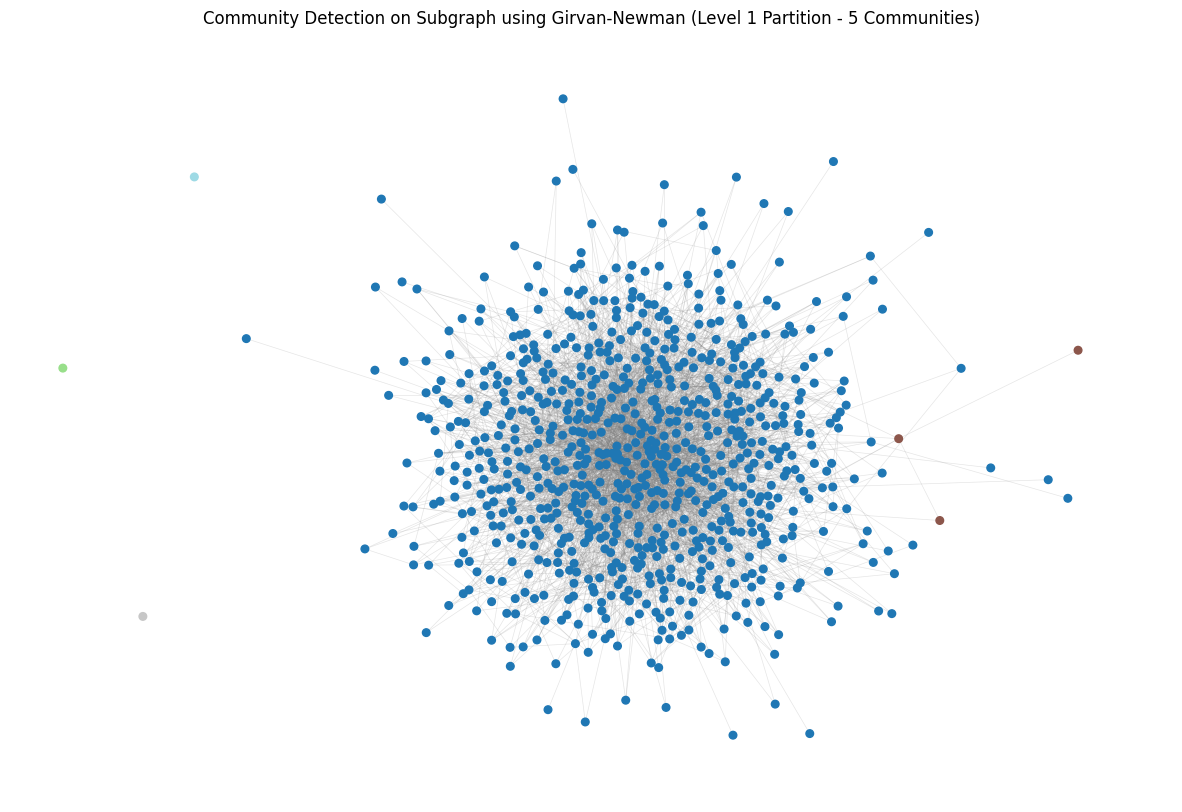

In [18]:
# --- 4. Community Detection (Girvan-Newman - on Subgraph) --- # MODIFIED
print("\n--- 4. Community Detection (Girvan-Newman - on Subgraph) ---") # MODIFIED
print("Attempting to compute the FIRST level partition on the subgraph.") # MODIFIED

# Check if subgraph G_sub exists and is not empty
if 'G_sub' in locals() and G_sub and G_sub.number_of_nodes() > 0: # MODIFIED Check G_sub
    communities_generator_sub = None # Initialize
    first_level_communities_sub = None
    num_communities_found_sub = 0
    start_time = pd.Timestamp.now() # Record start time

    try:
        # Get the Girvan-Newman community generator for the subgraph
        communities_generator_sub = nx.community.girvan_newman(G_sub) # MODIFIED G -> G_sub

        # --- Compute ONLY the first level ---
        print(f"Calculating level 1 partition (Subgraph)...")
        # next() gets the first partition from the generator
        first_level_tuple_sub = next(communities_generator_sub)
        first_level_communities_sub = [list(c) for c in first_level_tuple_sub]
        num_communities_found_sub = len(first_level_communities_sub)
        print(f"Level 1 (Subgraph): Found {num_communities_found_sub} communities.") # MODIFIED Note Subgraph
        end_time = pd.Timestamp.now()
        print(f"Calculation took: {end_time - start_time}") # Monitor time

    except StopIteration:
        print("Algorithm stopped unexpectedly before finding the first partition (Subgraph).") # MODIFIED Note Subgraph
    except Exception as e:
        print(f"An error occurred during Girvan-Newman level 1 calculation (Subgraph): {e}") # MODIFIED Note Subgraph

    # --- Visualization (Only if first level was found) ---
    if first_level_communities_sub and num_communities_found_sub > 0:
        print(f"\nVisualizing partition level 1 with {num_communities_found_sub} communities (Subgraph)...") # MODIFIED Note Subgraph
        print("Preparing visualization (calculating layout, assigning colors)...")

        print("Calculating spring layout for subgraph (may take time)...") # MODIFIED Note Subgraph
        try:
            # Layout for G_sub
            pos_sub = nx.spring_layout(G_sub, k=0.15, iterations=50, seed=42) # MODIFIED G -> G_sub, maybe more iterations ok
            print("Layout calculation complete (Subgraph).") # MODIFIED Note Subgraph

            node_community_mapping_sub = {}
            for i, comm in enumerate(first_level_communities_sub):
                for node in comm:
                    node_community_mapping_sub[node] = i

            # Use appropriate colormap
            if num_communities_found_sub <= 20:
                cmap = plt.cm.get_cmap('tab20', num_communities_found_sub)
            else:
                cmap = plt.cm.get_cmap('rainbow', num_communities_found_sub)

            # Get node colors based on G_sub.nodes()
            node_colors_sub = [cmap(node_community_mapping_sub.get(node, -1)) for node in G_sub.nodes()] # MODIFIED use G_sub.nodes()

            print("Drawing subgraph with community colors...") # MODIFIED Note Subgraph
            plt.figure(figsize=(15, 10)) # Keep plot size reasonable

            # Draw subgraph nodes and edges
            nx.draw_networkx_nodes(G_sub, pos_sub, node_size=30, # Slightly larger nodes might be ok
                                   node_color=node_colors_sub, cmap=cmap) # MODIFIED variables
            nx.draw_networkx_edges(G_sub, pos_sub, alpha=0.2, width=0.5, edge_color='grey') # MODIFIED variables

            plt.title(f'Community Detection on Subgraph using Girvan-Newman (Level 1 Partition - {num_communities_found_sub} Communities)') # MODIFIED Title
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred during visualization (Subgraph): {e}") # MODIFIED Note Subgraph
    else:
        print("\nCould not obtain the first level communities from Girvan-Newman to plot (Subgraph).") # MODIFIED Note Subgraph

else:
    print("Subgraph 'G_sub' is not created or is empty. Cannot perform Community Detection.") # MODIFIED Check G_sub

# --- Cleanup generator ---
if 'communities_generator_sub' in locals() and communities_generator_sub is not None:
    try:
         getattr(communities_generator_sub, 'close', lambda: None)()
    except Exception:
        pass
    # Optional: del communities_generator_sub # Keep variable if needed later?

In [19]:
# --- 5. Shortest Paths (on Subgraph) --- # MODIFIED
print("\n--- 5. Shortest Paths (on Subgraph) ---") # MODIFIED

if 'G_sub' in locals() and G_sub and G_sub.number_of_nodes() > 0: # MODIFIED Check G_sub

    # --- Identify Connected Components of the Subgraph ---
    # nx.connected_components returns a generator of sets of nodes
    subgraph_components = list(nx.connected_components(G_sub)) # MODIFIED G -> G_sub

    if subgraph_components: # Check if there are any components
        # --- Find the Largest Connected Component (LCC) of the Subgraph ---
        print(f"Subgraph has {len(subgraph_components)} connected component(s).")
        largest_cc_nodes_sub = max(subgraph_components, key=len)
        LCC_sub = G_sub.subgraph(largest_cc_nodes_sub).copy() # Create subgraph of the largest component
        print(f"Largest Connected Component (LCC) of the subgraph identified.")
        print(f"  Number of nodes in LCC_sub: {LCC_sub.number_of_nodes()}")
        print(f"  Number of edges in LCC_sub: {LCC_sub.number_of_edges()}")

        # --- Shortest Path Function ---
        # Develop a function where the user enter the IDs of two nodes,
        # then find and show the shortest path between them.
        # For demonstration, we'll use nodes from LCC_sub.
        def find_shortest_path_subgraph(graph_component, node1, node2): # Function specific to components
            """Finds and prints the shortest path between node1 and node2 WITHIN a given graph component."""
            print(f"\nFinding shortest path between Node {node1} and Node {node2} within their component...")
            if node1 not in graph_component:
                print(f"Error: Node {node1} not found in the provided graph component.")
                return
            if node2 not in graph_component:
                print(f"Error: Node {node2} not found in the provided graph component.")
                return

            try:
                path = nx.shortest_path(graph_component, source=node1, target=node2)
                path_str = ' -> '.join(map(str, path)) # Format path for printing
                print(f"  Shortest path: {path_str}")
                print(f"  Path length: {len(path) - 1} edge(s)")
            except nx.NetworkXNoPath:
                # This shouldn't happen if both nodes are in the same connected component graph
                print(f"  Error: No path exists between Node {node1} and Node {node2} (unexpected within a component).")
            except Exception as e:
                print(f"  An error occurred finding the path: {e}")

        # --- Example Usage of Shortest Path Function ---
        # Pick two random nodes *from the LCC_sub*
        if LCC_sub.number_of_nodes() >= 2:
            random_nodes_lcc = random.sample(list(LCC_sub.nodes()), 2)
            node_a, node_b = random_nodes_lcc[0], random_nodes_lcc[1]
            find_shortest_path_subgraph(LCC_sub, node_a, node_b)

            # Optional: Try path between top degree/betweenness nodes if they are in LCC_sub
            # Need max_bc_node_sub from Step 3
            top_deg_node_sub = sorted_degrees_sub[0][0] # Get top degree node ID from Step 3 result
            if ('max_bc_node_sub' in locals() and max_bc_node_sub and
                top_deg_node_sub in LCC_sub and max_bc_node_sub in LCC_sub and
                top_deg_node_sub != max_bc_node_sub):
                 print("\nAttempting path between top degree and top betweenness nodes (if in LCC_sub):")
                 find_shortest_path_subgraph(LCC_sub, top_deg_node_sub, max_bc_node_sub)
            else:
                 print("\nNote: Top degree/betweenness nodes are not both distinct and within the LCC_sub.")

        else:
            print("\nLCC_sub has fewer than 2 nodes, cannot find a path.")


        # --- Calculate Average Shortest Path Length for LCC_sub ---
        # This metric only makes sense for a connected component.
        if LCC_sub.number_of_nodes() > 1:
            print("\nCalculating average shortest path length for the LCC of the subgraph...")
            try:
                avg_shortest_path_lcc_sub = nx.average_shortest_path_length(LCC_sub) # Use LCC_sub
                print(f"  Average shortest path length in LCC_sub: {avg_shortest_path_lcc_sub:.4f}")
            except Exception as e:
                print(f"  Could not calculate average shortest path length for LCC_sub. Error: {e}")
        else:
             print("\nLCC_sub has only one node, average shortest path length is undefined.")

    else:
        print("Subgraph has no components (it's empty).")

else:
    print("Subgraph 'G_sub' is not created or is empty. Cannot perform Shortest Path analysis.") # MODIFIED Check G_sub


--- 5. Shortest Paths (on Subgraph) ---
Subgraph has 4 connected component(s).
Largest Connected Component (LCC) of the subgraph identified.
  Number of nodes in LCC_sub: 797
  Number of edges in LCC_sub: 3562

Finding shortest path between Node 1940 and Node 700 within their component...
  Shortest path: 1940 -> 1781 -> 700
  Path length: 2 edge(s)

Note: Top degree/betweenness nodes are not both distinct and within the LCC_sub.

Calculating average shortest path length for the LCC of the subgraph...
  Average shortest path length in LCC_sub: 3.0015



--- 6. Visualization (LCC of Subgraph) ---
Plotting the Largest Connected Component (LCC) of the subgraph.
Node size will be proportional to degree within the LCC.
Calculating degrees within LCC_sub...
Calculating spring layout for LCC_sub (may take time)...
Layout calculation complete (LCC_sub).
Drawing LCC_sub graph...


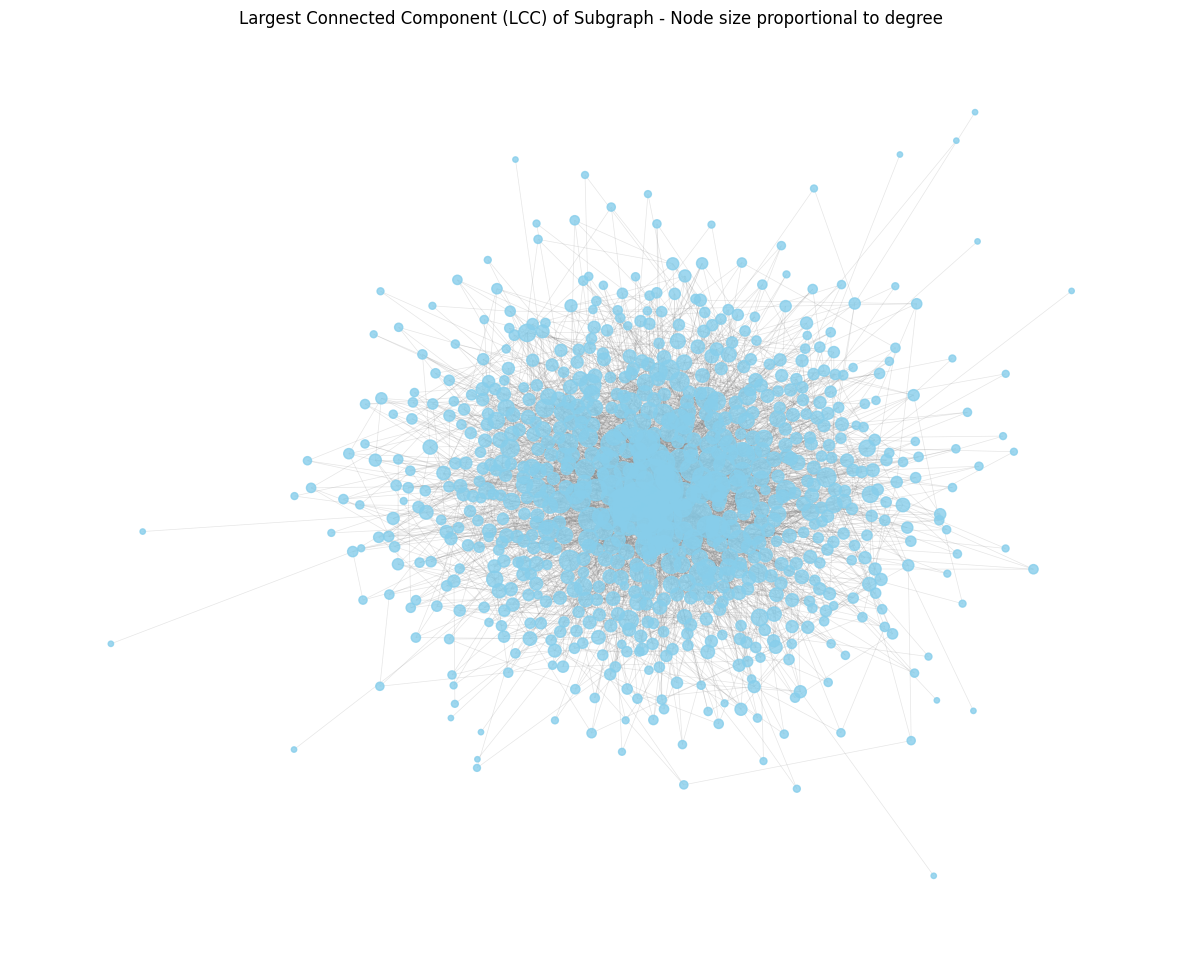


--- 7. Extra Notes ---
- Analysis was performed on a subgraph of 800 nodes due to performance limitations of Girvan-Newman on the full dataset.
- The subgraph was generated by random node sampling, resulting in 4 connected components.
- Shortest path and visualization focused on the largest connected component (LCC) of the subgraph (797 nodes).
- Key findings include Node 107 being central in both the full graph (based on initial check) and the subgraph (degree and betweenness).
- The LCC of the subgraph exhibits small-world properties (average shortest path length ~3.00).


In [20]:
# --- 6. Visualization (LCC of Subgraph) --- # MODIFIED
print("\n--- 6. Visualization (LCC of Subgraph) ---") # MODIFIED
print("Plotting the Largest Connected Component (LCC) of the subgraph.") # MODIFIED
print("Node size will be proportional to degree within the LCC.") # MODIFIED

# Check if LCC_sub was created in Step 5
if 'LCC_sub' in locals() and LCC_sub and LCC_sub.number_of_nodes() > 0:

    # --- Calculate Degrees within LCC_sub ---
    print("Calculating degrees within LCC_sub...")
    lcc_sub_degrees = dict(LCC_sub.degree()) # Use LCC_sub

    # --- Determine Node Sizes ---
    # Scale degrees for visibility. Adjust multiplier (e.g., 5, 10, 20) as needed.
    # Add a small base size (e.g., 5) so nodes with degree 0 (if any) are visible.
    size_multiplier = 10
    base_size = 5
    node_sizes = [base_size + lcc_sub_degrees.get(node, 0) * size_multiplier for node in LCC_sub.nodes()]

    # --- Calculate Layout for LCC_sub ---
    # Using a different layout calculation specifically for the LCC might give better results
    # than trying to reuse a layout from the whole subgraph.
    print("Calculating spring layout for LCC_sub (may take time)...")
    try:
        # Use more iterations for potentially better layout on the smaller LCC
        pos_lcc_sub = nx.spring_layout(LCC_sub, k=0.1, iterations=50, seed=42) # Layout for LCC_sub
        print("Layout calculation complete (LCC_sub).")

        # --- Draw the Plot ---
        print("Drawing LCC_sub graph...")
        plt.figure(figsize=(15, 12)) # Adjust figure size if needed

        # Draw nodes
        nx.draw_networkx_nodes(
            LCC_sub,
            pos_lcc_sub,
            node_size=node_sizes, # Use calculated sizes
            node_color='skyblue',  # Single color for this plot
            alpha=0.8             # Slight transparency
        )

        # Draw edges
        nx.draw_networkx_edges(
            LCC_sub,
            pos_lcc_sub,
            edge_color='grey',
            alpha=0.2,          # More transparent edges
            width=0.5           # Thin edges
        )

        plt.title('Largest Connected Component (LCC) of Subgraph - Node size proportional to degree') # MODIFIED Title
        plt.xlabel("Layout X-coordinate")
        plt.ylabel("Layout Y-coordinate")
        plt.axis('off') # Hide axes for cleaner look
        plt.show()

    except Exception as e:
        print(f"An error occurred during LCC_sub layout or plotting: {e}")

else:
    print("Largest Connected Component of Subgraph ('LCC_sub') not available. Cannot visualize.")

# --- 7. Extra --- (Placeholder, add final comments here) ---
print("\n--- 7. Extra Notes ---")
print("- Analysis was performed on a subgraph of 800 nodes due to performance limitations of Girvan-Newman on the full dataset.")
print("- The subgraph was generated by random node sampling, resulting in 4 connected components.")
print("- Shortest path and visualization focused on the largest connected component (LCC) of the subgraph (797 nodes).")
print("- Key findings include Node 107 being central in both the full graph (based on initial check) and the subgraph (degree and betweenness).")
print("- The LCC of the subgraph exhibits small-world properties (average shortest path length ~3.00).")
# Add any other observations or conclusions